# Missing RPE Data

On some of the game dates, we don't have RPE data. But, we are mainly concerned with the acute/chronic ratio which we can compute for the dates for which it is missing.

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(5151)
raw_rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
raw_rpe = raw_rpe_df.copy()[['Date', 'PlayerID', 'RPE']]
print(raw_rpe_df.head())


   Unnamed: 0        Date  PlayerID  Training SessionType  Duration  RPE  \
0           0  2017-08-01        15         1    Strength      60.0  4.0   
1           1  2017-08-01         1         1       Speed      60.0  3.0   
2           2  2017-08-01         1         1    Strength      90.0  4.0   
3           3  2017-08-01         3         1       Speed      45.0  5.0   
4           4  2017-08-01         3         1    Strength      90.0  5.0   

   SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0        240.0      300.0               4.29              6.0          7.0   
1        180.0      540.0               4.29              0.0          0.0   
2        360.0      540.0               4.29              0.0          0.0   
3        225.0      675.0               4.29              7.0          7.0   
4        450.0      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              3.0      42.86

## Drop Duplicate Dates

This occurs when there are multiple training sessions on the same date. We only care about the daily load so we can drop the duplicate sessions.

In [3]:
rpe_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'DailyLoad', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad']]
subjective_performance_df = raw_rpe_df.copy()[['Date', 'PlayerID', 'ObjectiveRating', 'FocusRating', 'BestOutOfMyself']]
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
2,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
4,2017-08-01,3,675.0,4.29,96.43,22.5


In [4]:
subjective_performance_df.head()

,Date,PlayerID,ObjectiveRating,FocusRating,BestOutOfMyself
0,2017-08-01,15,6.0,7.0,3.0
1,2017-08-01,1,0.0,0.0,3.0
2,2017-08-01,1,0.0,0.0,3.0
3,2017-08-01,3,7.0,7.0,3.0
4,2017-08-01,3,7.0,7.0,3.0


In [5]:
rpe_df = rpe_df.drop_duplicates()

In [6]:
rpe_df.head()

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,15,300.0,4.29,42.86,10.0
1,2017-08-01,1,540.0,4.29,77.14,18.0
3,2017-08-01,3,675.0,4.29,96.43,22.5
5,2017-08-01,5,330.0,4.29,47.14,11.0
7,2017-08-01,8,345.0,4.29,49.29,11.5


## Fill In Missing RPE Data

This row should not be in the dataset since it is the first entry for this player and they are not training.

In [7]:
rpe_df = rpe_df[~ rpe_df['AcuteChronicRatio'].isnull()]

In [8]:
rpe_df['Date'] = pd.to_datetime(rpe_df['Date'])

Adding missing dates and player ids to rpe data:

In [9]:
dates = pd.date_range(start=min(rpe_df['Date']), end=max(rpe_df['Date']))
players = rpe_df['PlayerID'].unique()
idx = pd.MultiIndex.from_product((dates, players), names=['Date', 'PlayerID'])

rpe_df = rpe_df.set_index(['Date', 'PlayerID']).reindex(idx, fill_value=0).reset_index().sort_values(by=['Date', 'PlayerID'])



Use a rolling window to compute acute load and chronic load:

In [10]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how='left', on=['Date', 'PlayerID'])

In [11]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])

In [12]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)
rpe_df[rpe_df['PlayerID'] == 1]

,Date,PlayerID,DailyLoad,AcuteChronicRatio,AcuteLoad,ChronicLoad
0,2017-08-01,1,540.0,4.29,77.14,18.00
17,2017-08-02,1,0.0,4.29,77.14,18.00
34,2017-08-03,1,0.0,4.29,77.14,18.00
51,2017-08-04,1,0.0,4.29,77.14,18.00
68,2017-08-05,1,0.0,4.29,77.14,18.00
85,2017-08-06,1,0.0,4.29,77.14,18.00
102,2017-08-07,1,720.0,4.29,180.00,42.00
119,2017-08-08,1,0.0,2.45,102.86,42.00
136,2017-08-09,1,0.0,2.45,102.86,42.00
153,2017-08-10,1,0.0,2.45,102.86,42.00


In [13]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
gps_df.head()


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame
0,2017-11-30,1,W,19,2,7.284728,4.423615
1,2017-11-30,1,W,19,3,6.852436,4.888893
2,2017-11-30,1,W,19,4,7.267784,5.694449
3,2017-11-30,1,W,19,6,6.338894,4.777782
4,2017-11-30,1,W,19,7,7.065283,4.091273


In [14]:
# merged_df = gps_df.merge(rpe_df, how='left', on=['Date', 'PlayerID'])
# merged_df.head()
gps_df['Date'] = pd.to_datetime(gps_df['Date'])
train_performance = gps_df.merge(rpe_df[[
    'Date','PlayerID', 'AcuteLoad',
    'ChronicLoad','AcuteChronicRatio']],
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(train_performance))
train_performance.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50


In [15]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'])
wellness_df.head()

,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness,wellness
0,2018-07-21,1,13,0,1,3,3,-1.450204,0.364611,0.301008,0.722090,-1.826823,-1.889318
1,2018-07-21,2,19,0,0,3,3,0.170622,-2.742646,0.301008,0.722090,-1.826823,-3.375750
2,2018-07-21,3,19,100,1,3,3,0.170622,0.364611,0.301008,0.722090,0.795746,2.354077
3,2018-07-21,4,15,95,1,3,3,-0.909929,0.364611,0.301008,0.722090,0.664618,1.142398
4,2018-07-21,5,20,100,1,3,2,0.440759,0.364611,0.301008,-1.220149,0.795746,0.681976


Impute wellness data for missing dates (if we merge without doing this there are 12 instances of performance data that have no wellness data):

In [16]:
wellness_dates = pd.date_range(start=min(train_performance['Date']), end=max(train_performance['Date']))
wellness_players = wellness_df['PlayerID'].unique()
wellness_idx = pd.MultiIndex.from_product((wellness_dates, wellness_players), names=['Date', 'PlayerID'])

wellness_df = wellness_df.set_index(['Date', 'PlayerID']).reindex(wellness_idx).reset_index().sort_values(by=['Date', 'PlayerID'])

wellness_df[wellness_df['MonitoringScore'].isnull()].shape

(779, 13)

In [17]:
print(len(wellness_df))

3978


We see that there are 779 observations where we need to forward fill to impute the wellness data. This is out of 3978 observations after we reindex the data which is 20% of the observations.

In [18]:
wellness_df = wellness_df.fillna(method='ffill')

In [19]:
merged_df = train_performance.merge(wellness_df,
    how='left', on= ['Date','PlayerID']).drop_duplicates()
print(len(merged_df))
merged_df.head()

443


,Date,GameID,Outcome,TeamPoints,PlayerID,MaxSpeedInGame,MaxAccelImpulseInGame,AcuteLoad,ChronicLoad,AcuteChronicRatio,...,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness,wellness
0,2017-11-30,1,W,19,2,7.284728,4.423615,206.57,371.20,0.56,...,0.0,1.0,3.0,2.0,0.981035,0.364611,0.301008,-1.220149,-1.826823,-1.400318
1,2017-11-30,1,W,19,3,6.852436,4.888893,407.86,454.67,0.90,...,100.0,1.0,3.0,3.0,1.251172,0.364611,0.301008,0.722090,0.795746,3.434628
2,2017-11-30,1,W,19,4,7.267784,5.694449,236.00,406.90,0.58,...,100.0,1.0,3.0,3.0,0.710897,0.364611,0.301008,0.722090,0.795746,2.894352
3,2017-11-30,1,W,19,6,6.338894,4.777782,297.29,415.87,0.71,...,90.0,1.0,3.0,3.0,0.440759,0.364611,0.301008,0.722090,0.533489,2.361958
4,2017-11-30,1,W,19,7,7.065283,4.091273,237.57,476.60,0.50,...,95.0,1.0,3.0,3.0,1.251172,0.364611,0.301008,0.722090,0.664618,3.303499


In [20]:
print(merged_df[merged_df['MonitoringScore'].isnull()])

Empty DataFrame
Columns: [Date, GameID, Outcome, TeamPoints, PlayerID, MaxSpeedInGame, MaxAccelImpulseInGame, AcuteLoad, ChronicLoad, AcuteChronicRatio, MonitoringScore, TrainingReadiness, Pain, Illness, Nutrition, StandardizedMonitoringScore, StandardizedPain, StandardizedIllness, StandardizedNutrition, StandardizedTrainingReadiness, wellness]
Index: []

[0 rows x 21 columns]


In [21]:
merged_df.to_csv('./processed_data/merged_df.csv')

## Correlations Between Predictors and Response

Based on our previous analysis, we think that `AcuteChronicRatio`, `MonitoringScore`, `Pain`, `Illness`, `Nutrition` will be predictors for `MaxSpeedInGame` which is our measure for performance. We also have an overall score for wellness called `wellness` which is the combination of all predictors other than `AcuteChronicRatio`.

In [22]:
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()

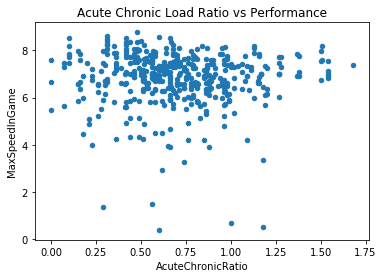

In [23]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'MaxSpeedInGame', 'Acute Chronic Load Ratio vs Performance')


It does not look like there is any clear pattern between load and performance.

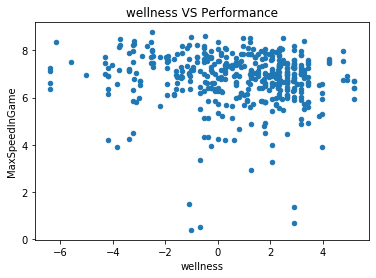

In [24]:
scatter_plot(merged_df, 'wellness', 'MaxSpeedInGame', 'wellness VS Performance')


In [25]:
merged_df['wellness'].corr(merged_df['MaxSpeedInGame'])

-0.08918453503221264

In [26]:
grouped_merged_df = merged_df[['wellness', 'MaxSpeedInGame', 'PlayerID']].groupby('PlayerID').mean()
grouped_merged_df

,wellness,MaxSpeedInGame
PlayerID,,
1,-0.744741,7.683961
2,-2.418550,6.632284
3,2.676770,6.826691
4,1.669272,6.632953
5,-0.001545,7.721914
6,1.637513,6.511335
7,1.145357,7.210339
8,1.392609,6.960623
9,0.073373,6.931128


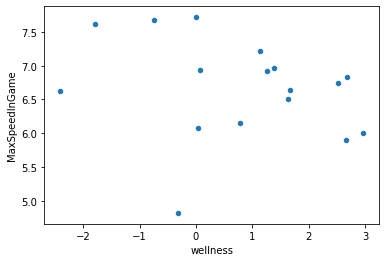

In [27]:
scatter_plot(grouped_merged_df, 'wellness', 'MaxSpeedInGame')

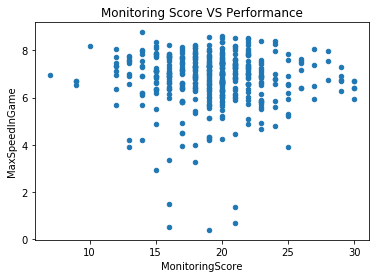

In [28]:
scatter_plot(merged_df, 'MonitoringScore', 'MaxSpeedInGame', 'Monitoring Score VS Performance')


In [29]:
merged_df['MonitoringScore'].corr(merged_df['MaxSpeedInGame'])

-0.02071922117430437

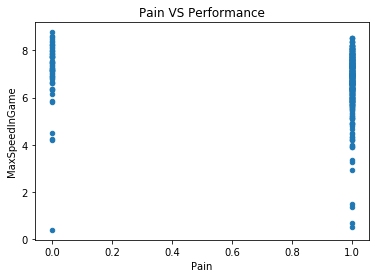

In [30]:
scatter_plot(merged_df, 'Pain', 'MaxSpeedInGame', 'Pain VS Performance')

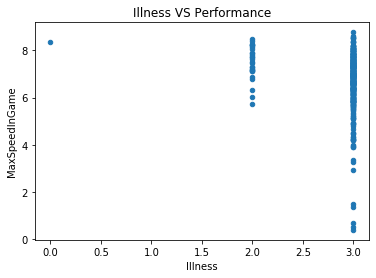

In [31]:
scatter_plot(merged_df, 'Illness', 'MaxSpeedInGame', 'Illness VS Performance')

In [52]:
ttest_ind(merged_df[merged_df['Illness'] == 2]['MaxSpeedInGame'], merged_df[merged_df['Illness'] == 3]['MaxSpeedInGame'])

Ttest_indResult(statistic=3.379531596808848, pvalue=0.0007907843577221889)

We get a significant results that the performance of those saying they are slightly off is better than those who are not ill.

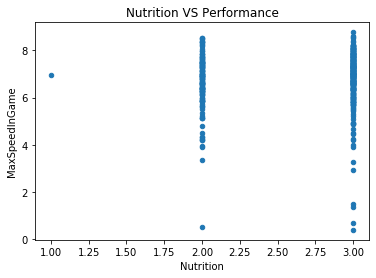

In [32]:
scatter_plot(merged_df, 'Nutrition', 'MaxSpeedInGame', 'Nutrition VS Performance')

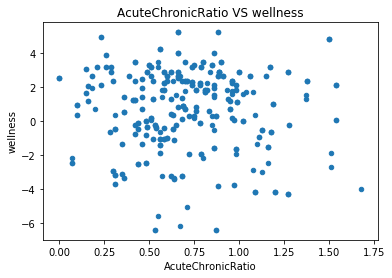

In [33]:
scatter_plot(merged_df, 'AcuteChronicRatio', 'wellness', 'AcuteChronicRatio VS wellness')

We see that there are no clear patterns when we are looking at the repeated measures data. Maybe we will get something out of using a mixed models regression.

## Ideas Going Forward

We also need to investigate the affect of wellness on load independent of performance. For example, look at the daily load to next day's wellness. Also look at wellness to current daily load (ie, does wellness affect RPE?).

### Regression Examples

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [35]:
merged_df['SquaredAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 2
merged_df['CubedAcuteChronicRatio'] = merged_df['AcuteChronicRatio'] ** 3

fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()
mod = smf.gee("MaxSpeedInGame ~ AcuteChronicRatio + SquaredAcuteChronicRatio +  MonitoringScore + TrainingReadiness + Illness + Pain + Nutrition", "PlayerID", merged_df, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  443
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                26.1
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Mon, 02 Dec 2019   Scale:                           1.279
Covariance type:                    robust   Time:                         11:28:31
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.4007      0.589     12.574 

#### Plot Residuals

In [42]:
#gee_predictions = mod.predict(merged_df[['AcuteChronicRatio', 'SquaredAcuteChronicRatio', 'MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition']])
gee_predictions = res.predict()
residual_df = merged_df.copy()[['AcuteChronicRatio', 'MonitoringScore', 'TrainingReadiness', 'Illness', 'Pain', 'Nutrition', 'MaxSpeedInGame']]
residual_df['Prediction'] = gee_predictions
residual_df['Residuals'] = residual_df['MaxSpeedInGame'] - residual_df['Prediction']
residual_df.head()


,AcuteChronicRatio,MonitoringScore,TrainingReadiness,Illness,Pain,Nutrition,MaxSpeedInGame,Prediction,Residuals
0,0.56,22.0,0.0,3.0,1.0,2.0,7.284728,6.717238,0.567490
1,0.90,23.0,100.0,3.0,1.0,3.0,6.852436,6.698022,0.154414
2,0.58,21.0,100.0,3.0,1.0,3.0,7.267784,6.712459,0.555325
3,0.71,20.0,90.0,3.0,1.0,3.0,6.338894,6.694846,-0.355952
4,0.50,23.0,95.0,3.0,1.0,3.0,7.065283,6.766871,0.298413


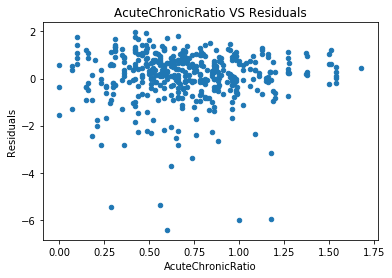

In [43]:
scatter_plot(residual_df, 'AcuteChronicRatio', 'Residuals', 'AcuteChronicRatio VS Residuals')

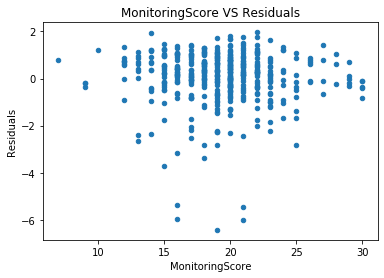

In [44]:
scatter_plot(residual_df, 'MonitoringScore', 'Residuals', 'MonitoringScore VS Residuals')

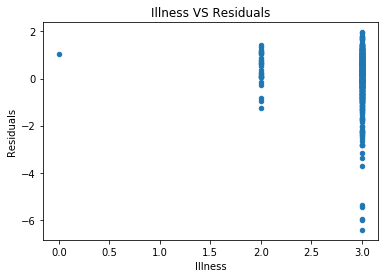

In [45]:
scatter_plot(residual_df, 'Illness', 'Residuals', 'Illness VS Residuals')

In [53]:
ttest_ind(residual_df[residual_df['Illness'] == 2]['Residuals'], residual_df[residual_df['Illness'] == 3]['Residuals'])

Ttest_indResult(statistic=1.8139120173474979, pvalue=0.07037229856570243)

No significant difference in the residuals for Illness = 2 or Illness = 3

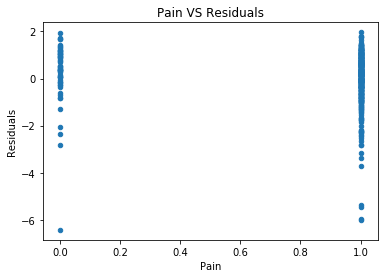

In [46]:
scatter_plot(residual_df, 'Pain', 'Residuals', 'Pain VS Residuals')

In [50]:
ttest_ind(residual_df[residual_df['Pain'] == 0]['Residuals'], residual_df[residual_df['Pain'] == 1]['Residuals'])

Ttest_indResult(statistic=1.4171700941776058, pvalue=0.1571392780332031)

No significant difference between mean residuals for pain = 0 or pain = 1

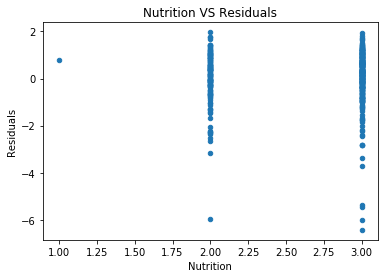

In [47]:
scatter_plot(residual_df, 'Nutrition', 'Residuals', 'Nutrition VS Residuals')

In [51]:
ttest_ind(residual_df[residual_df['Nutrition'] == 2]['Residuals'], residual_df[residual_df['Nutrition'] == 3]['Residuals'])

Ttest_indResult(statistic=-0.4669269936771026, pvalue=0.640783232980543)

No significant difference between mean residuals for Nutrition = 2 or Nutrition = 3

In [ ]:
mixed = smf.mixedlm("MaxSpeedInGame ~ AcuteChronicRatio + SquaredAcuteChronicRatio +  MonitoringScore + TrainingReadiness + Illness + Pain + Nutrition", merged_df, groups = merged_df["PlayerID"])
mixed_fit = mixed.fit()
print(mixed_fit.summary())


## RPE and Wellness

In [ ]:
raw_rpe['Date'] = pd.to_datetime(raw_rpe['Date'])
rpe_wellness = wellness_df.merge(raw_rpe, on=['Date', 'PlayerID'])
rpe_wellness.head()

In [ ]:
rpe_wellness = rpe_wellness.dropna()
rpe_wellness_mixed = smf.mixedlm("RPE ~ wellness", rpe_wellness, groups = rpe_wellness["PlayerID"])
rpe_wellness_mixed_fit = rpe_wellness_mixed.fit()
print(rpe_wellness_mixed_fit.summary())


In [ ]:
model_rpe_wellness = rpe_wellness.dropna()
model_rpe_wellness[['RPE']] = StandardScaler().fit_transform(model_rpe_wellness[['RPE']])

rpe_wellness_mixed = smf.mixedlm("RPE ~ MonitoringScore + TrainingReadiness + Pain + Illness + Nutrition", model_rpe_wellness, groups = model_rpe_wellness["PlayerID"])
rpe_wellness_mixed_fit = rpe_wellness_mixed.fit()
print(rpe_wellness_mixed_fit.summary())


In [ ]:
rpe_wellness['RPE'].corr(rpe_wellness['wellness'])


In [ ]:
grouped_rpe_wellness = rpe_wellness[['PlayerID', 'wellness', 'RPE']].groupby(['PlayerID']).mean()
grouped_rpe_wellness

In [ ]:
grouped_rpe_wellness.corr()

In [ ]:
grouped_rpe_wellness.plot.scatter('wellness', 'RPE')

There is no general trend in average wellness and RPE

## Wellness vs Subjective Performance

In [ ]:
subjective_performance_df.head()

Remember, Best Out Of Myself was lives on a scale of 0, 1, or 3 scale so we should standardize all the values so they can be combined into one measure of subjective performance.

In [ ]:
subjective_performance_scaler = StandardScaler()
standardized_subjective_performance_values = subjective_performance_scaler.fit_transform(subjective_performance_df[['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']])
subjective_performance_df['StandardizedObjectiveRating'] = standardized_subjective_performance_values[:, 0]
subjective_performance_df['StandardizedFocusRating'] = standardized_subjective_performance_values[:, 1]
subjective_performance_df['StandardizedBestOutOfMyself'] = standardized_subjective_performance_values[:, 2]
subjective_performance_df['SubjectivePerformance'] = subjective_performance_df['StandardizedObjectiveRating'] + subjective_performance_df['StandardizedFocusRating'] + subjective_performance_df['StandardizedBestOutOfMyself']
subjective_performance_df.head()


In [ ]:
wellness_df.head()

In [ ]:
subjective_performance_df['Date'] = pd.to_datetime(subjective_performance_df['Date'])
wellness_subjective_performance = wellness_df.merge(subjective_performance_df, how='inner', on= ['Date','PlayerID'])
wellness_subjective_performance.head()


In [ ]:
scatter_plot(wellness_subjective_performance, 'wellness', 'SubjectivePerformance', 'SubjectivePerformance VS wellness')


In [ ]:
averaged_subjective_perofrmance = wellness_subjective_performance[['PlayerID', 'wellness', 'SubjectivePerformance']].groupby('PlayerID').mean()
averaged_subjective_perofrmance


In [ ]:
scatter_plot(averaged_subjective_perofrmance, 'wellness', 'SubjectivePerformance', 'SubjectivePerformance VS wellness')


### Plot Subjective Performance Over Time For Each Player

In [ ]:
for player_id in wellness_subjective_performance['PlayerID'].unique():
    player_df = wellness_subjective_performance[wellness_subjective_performance['PlayerID'] == player_id]
    plt.plot(player_df['Date'], player_df['wellness'])
    plt.title('Wellness over time for player {}'.format(player_id))
    plt.show()
    plt.plot(player_df['Date'], player_df['SubjectivePerformance'])
    plt.title('SubjectivePerformance over time for player {}'.format(player_id))
    plt.show()


## Looking Deeper Into Pain and Illness

When we look at Pain, Illness, and Nutrition vs performance, it almost looks like the average performance for being in pain is less than not being in pain which is counter intuitive. The same goes for nutrition. We should formalize these findings by doing a t-test.

In [ ]:
averaged_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'Pain', 'Illness', 'Nutrition', 'AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad', 'wellness', 'MonitoringScore', 'TrainingReadiness']].groupby('PlayerID').mean()
averaged_df


In [ ]:
averaged_df.corr()

Remember that taking the correlation of averaged values for repreated measures might not be the best thing to do, (find citation for this - Joe)

### Pain

There were 10 players that were never in pain (ie average pain = 1) so lets compare those players against those that were in pain.

In [ ]:
not_in_pain = averaged_df[averaged_df['Pain'] == 1]
not_in_pain['MaxSpeedInGame'].mean()

In [ ]:
in_pain = averaged_df[averaged_df['Pain'] != 1]
in_pain['MaxSpeedInGame'].mean()

It seems like those why were not in pain had lower average performance than those who were not in pain which seems counter intuitive. Let's first see if this difference was significant.

In [ ]:
ttest_ind(not_in_pain['MaxSpeedInGame'], in_pain['MaxSpeedInGame'])

This is a significant result. There must be something more to this relationship.

#### No Pain Players

In [ ]:
not_in_pain.index

In [ ]:
averaged_df.loc[not_in_pain.index][[]]

#### Pain Players

In [ ]:
in_pain.index

In [ ]:
averaged_df.loc[not_in_pain.index][['MaxSpeedInGame', 'Pain', 'Illness', 'Nutrition', '']]

## Performance For High And Low Wellness Occurances

In [ ]:
# Need to average over all the players so we have independent measurements
averaged_wellness_df = merged_df.copy()[['PlayerID', 'MaxSpeedInGame', 'wellness']].groupby('PlayerID').mean()
wellness_median = averaged_wellness_df['wellness'].median()

low_wellness_df = merged_df[merged_df['wellness'] < wellness_median]
high_wellness_df = merged_df[merged_df['wellness'] > wellness_median]

ttest_ind(low_wellness_df['MaxSpeedInGame'], high_wellness_df['MaxSpeedInGame'])

As expected, we see that there is no significant difference between average performance of high and low wellness players.